In [2]:
import glob
import pandas as pd

### I. Forming the Dataframe

In [6]:
# getting all cases after 2015 and concatenating them into one dataframe

columns = ['ddl_case_id', 'year', 'state_code', 'dist_code', 'court_no', 'judge_position', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name', 'disp_name']
cases = pd.concat([pd.read_csv(f, usecols = columns) for f in glob.glob('./csv/cases/*.csv') if int(f[18:22]) > 2015], ignore_index = True)

In [9]:
# read acts_sections.csv using chunking and merge with cases each chunk

columns = ['ddl_case_id', 'act', 'criminal']

# read acts_sections.csv for only the columns we need and if the ddl_case_id is in the cases dataframe

acts_sections = pd.read_csv('./csv/acts_sections.csv', usecols = columns)

In [10]:
# merge cases with acts_sections based on ddl_case_id

cases = pd.merge(cases, acts_sections, on='ddl_case_id', how='left')

cases.head()

### II. Data Cleaning & Preprocessing

In [3]:
cases_pre = cases.copy()

# removing columns that are not needed for the analysis
cases_pre = cases_pre.drop(['date_first_list', 'date_last_list', 'date_next_list', 'cino', 'date_of_filing', 'date_of_decision', 'ddl_case_id'], axis=1)
cases_pre = cases_pre.drop_duplicates()

print(cases_pre.shape)

(10419745, 12)


In [4]:
# removing strings from the columns and making them integers

cases_pre['female_defendant'] = cases_pre['female_defendant'].str.replace('[a-zA-Z]', '', regex=True).astype('int')
cases_pre['female_petitioner'] = cases_pre['female_petitioner'].str.replace('[a-zA-Z]', '', regex=True).astype('int')

In [5]:
# remove cases where the genders are not mentioned or unclear 

cases_pre = cases_pre.loc[(cases_pre['female_adv_def'] != -9999) & (cases_pre['female_adv_def'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_adv_pet'] != -9999) & (cases_pre['female_adv_pet'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_defendant'] != -9999) & (cases_pre['female_defendant'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_petitioner'] != -9999) & (cases_pre['female_petitioner'] != -9998)]

In [6]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,chief judicial magistrate,0,1,1,0,1940.0,2813.0,16
11,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,5426.0,23
12,2016,1,1,1,chief judicial magistrate,0,1,0,1,1940.0,2813.0,27
18,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,767.0,33
37,2016,1,1,1,chief judicial magistrate,0,0,0,0,1940.0,2813.0,46


#### Saving up on memory by downcasting the data types of the columns

In [7]:
# fill missing values with mode and drop all non-finite values

import numpy as np

# cases_pre = cases_pre.fillna(cases_pre.mode())
cases_pre = cases_pre.replace([np.inf, -np.inf], np.nan)
cases_pre = cases_pre.dropna()

In [8]:
cases_pre.dtypes

year                   int64
state_code             int64
dist_code              int64
court_no               int64
judge_position        object
female_defendant       int64
female_petitioner      int64
female_adv_def         int64
female_adv_pet         int64
type_name            float64
purpose_name         float64
disp_name              int64
dtype: object

In [9]:
cases_pre.memory_usage(deep=True)

Index                 4168248
year                  4168248
state_code            4168248
dist_code             4168248
court_no              4168248
judge_position       41445158
female_defendant      4168248
female_petitioner     4168248
female_adv_def        4168248
female_adv_pet        4168248
type_name             4168248
purpose_name          4168248
disp_name             4168248
dtype: int64

In [10]:
# downcasting the data types

cases_pre['judge_position'] = cases_pre['judge_position'].astype('category')
cases_pre['purpose_name'] = cases_pre['purpose_name'].astype('uint8')
cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name']] = cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name']].apply(pd.to_numeric, downcast='unsigned')

In [11]:
cases_pre.dtypes

year                   uint16
state_code              uint8
dist_code               uint8
court_no                uint8
judge_position       category
female_defendant        uint8
female_petitioner       uint8
female_adv_def          uint8
female_adv_pet          uint8
type_name              uint16
purpose_name            uint8
disp_name               uint8
dtype: object

In [12]:
# ordinal encoding of judge_position
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
cases_pre['judge_position'] = encoder.fit_transform(cases_pre[['judge_position']])
cases_pre['judge_position'] = cases_pre['judge_position'].astype('uint8')

In [85]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,107,0,1,1,0,1940,253,16
11,2016,1,1,1,107,0,1,0,0,1940,50,23
12,2016,1,1,1,107,0,1,0,1,1940,253,27
18,2016,1,1,1,107,0,1,0,0,1940,255,33
37,2016,1,1,1,107,0,0,0,0,1940,253,46


#### Compare the correlation of attributes to select the best ones for the model

<AxesSubplot: >

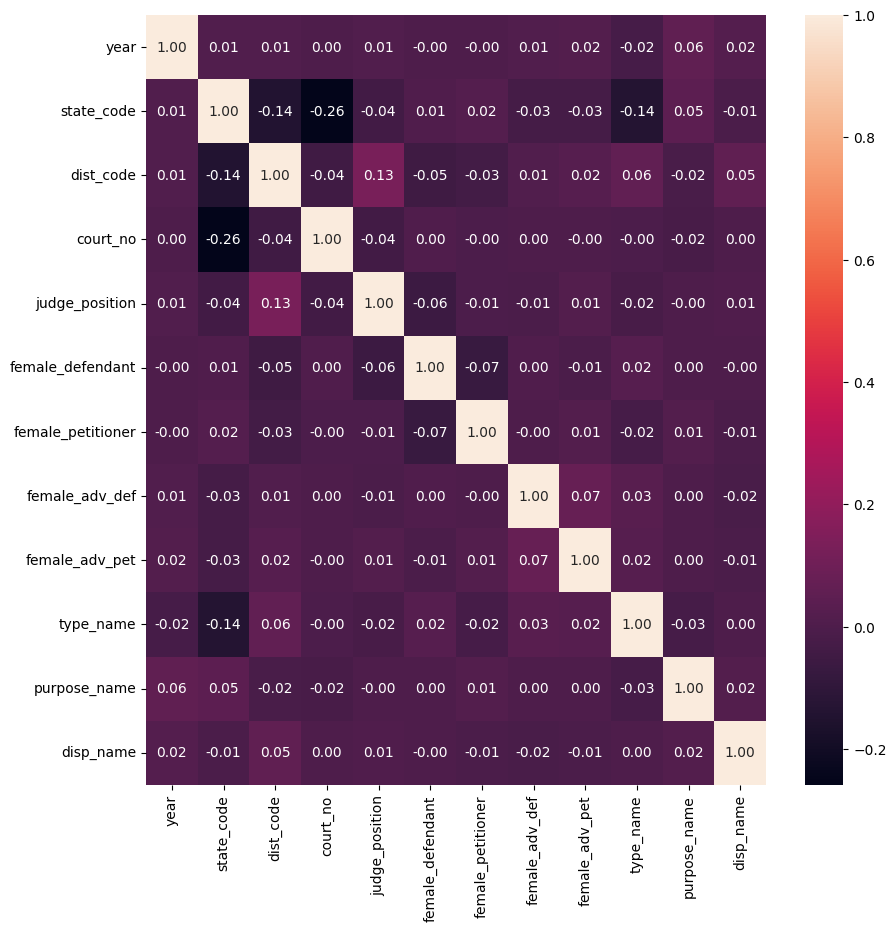

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# correlation matrix
corr = cases_pre.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f')

In [14]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,107,0,1,1,0,1940,253,16
11,2016,1,1,1,107,0,1,0,0,1940,50,23
12,2016,1,1,1,107,0,1,0,1,1940,253,27
18,2016,1,1,1,107,0,1,0,0,1940,255,33
37,2016,1,1,1,107,0,0,0,0,1940,253,46


#### Check which attribute is best to classify on

In [25]:
print(cases_pre['type_name'].nunique())
print(cases_pre['purpose_name'].nunique())
print(cases_pre['disp_name'].nunique())

print(cases_pre.shape)

5480
256
51
(521031, 12)


In [84]:
# merge with type_name_key csv to get the type_name in english and group similar type names together

# type_name_key = pd.read_csv('./csv/keys/type_name_key.csv')
# merged = pd.merge(cases_pre, type_name_key, on=['type_name', 'year'], how='left')
# merged = merged.drop(['type_name', 'count'], axis=1)

# print(merged.shape)

disp_name_key = pd.read_csv('./csv/keys/disp_name_key.csv')
merged = pd.merge(cases_pre, disp_name_key, on=['disp_name', 'year'], how='left')
merged = merged.drop(['disp_name', 'count'], axis=1)
# print(merged['type_name'].nunique())

In [85]:
merged.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name_s
0,2016,1,1,1,107,0,1,1,0,1940,253,compromise
1,2016,1,1,1,107,0,1,0,0,1940,50,dismissed
2,2016,1,1,1,107,0,1,0,1,1940,253,disposition var missing
3,2016,1,1,1,107,0,1,0,0,1940,255,other
4,2016,1,1,1,107,0,0,0,0,1940,253,settled


In [43]:
print(merged['disp_name_s'].unique())

['compromise' 'dismissed' 'disposition var missing' 'other' 'settled'
 'ex-parte' 'judgement' 'referred to lok adalat' 'allowed'
 'disposed-otherwise' 'decided' 'withdrawn' 'reject' 'acquitted'
 'compounded' 'transferred' 'abated' 'remanded' 'convicted' '258 crpc'
 'committed' 'probation' 'otherwise' 'disposed' 'plea bargaining'
 'procedural' 'died' 'award' 'partly decreed' 'closed' 'confession'
 'sine die' 'fine' 'uncontested' 'quash' 'plead guilty' 'appeal accepted'
 'contest-allowed' 'stayed' 'untrace' 'absconded' 'cancelled' 'not press'
 'bail granted' 'bail refused' 'execution' 'bail rejected' 'p.o. consign'
 'disposal in lok adalat' 'converted']


- compromise, settled, compounded, plea bargaining, not press
- dismissed, withdrawn, reject, abated, died, closed, sine die, quash, cancelled, 258 crpc
- other, disposition var missing, otherwise, ex-parte 
- judgement, referred to lok adalat, acquitted, remanded, convicted, committed, procedural, fine, decided, uncontested, appeal accepted, bail granted, bail refused, execution, bail rejected, disposed, disposed-otherwise, probation
- allowed, award, contest-allowed, partly decreed
- transferred, disposal in lok adalat
- confession, plead guilty
- stayed
- untrace
- converted, absconded
- po consign

In [86]:
# replace compromise, settled, compounded, plea bargaining, not press with compromise b/w parties
merged['disp_name_s'] = merged['disp_name_s'].replace(['compromise', 'settled', 'compounded', 'plea bargaining', 'not press'], 'compromise b/w parties')

# replace dismissed, withdrawn, reject, abated, died, closed, sine die, quash, cancelled, 258 crpc with dismissed/withdrawn
merged['disp_name_s'] = merged['disp_name_s'].replace(['dismissed', 'withdrawn', 'reject', 'abated', 'died', 'closed', 'sine die', 'quash', 'cancelled', '258 crpc'], 'dismissed/withdrawn')

# replace other, disposition var missing, otherwise, ex-parte with other
merged['disp_name_s'] = merged['disp_name_s'].replace(['disposition var missing', 'otherwise', 'ex-parte', 'stayed', 'untrace', 'p.o. consign'], 'other')

# replace judgement, referred to lok adalat, acquitted, remanded, convicted, committed, procedural, fine, decided, uncontested, appeal accepted, bail granted, bail refused, execution, bail rejected, disposed, disposed-otherwise, probation with court judgement
merged['disp_name_s'] = merged['disp_name_s'].replace(['judgement', 'acquitted', 'remanded', 'convicted', 'committed', 'procedural', 'fine', 'decided', 'uncontested', 'appeal accepted', 'bail granted', 'bail refused', 'execution', 'bail rejected', 'disposed', 'disposed-otherwise', 'probation'], 'court judgement')

# replace allowed, award, contest-allowed, partly decreed with in progress
merged['disp_name_s'] = merged['disp_name_s'].replace(['allowed', 'award', 'contest-allowed', 'partly decreed'], 'in progress')

# replace disposal in lok adalat, 'referred to lok adalat' with transferred
merged['disp_name_s'] = merged['disp_name_s'].replace(['disposal in lok adalat', 'referred to lok adalat'], 'transferred')

# replace confession, plead guilty with guilty
merged['disp_name_s'] = merged['disp_name_s'].replace(['confession', 'plead guilty'], 'guilty')

# replace converted, absconded with unlawful    
merged['disp_name_s'] = merged['disp_name_s'].replace(['converted', 'absconded'], 'unlawful')



In [67]:
# remove everything after the first word in type_name_s

merged['type_name_s'] = merged['type_name_s'].str.split(' ').str[0]

# ordinal encoding of type_name_s

merged['type_name_s'] = encoder.fit_transform(merged[['type_name_s']])
merged['type_name_s'] = merged['type_name_s'].astype('uint8')

merged.head()


,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,purpose_name,type_name_s,disp_name_s
0,2016,1,1,1,107,0,1,1,0,253,101,compromise b/w parties
1,2016,1,1,1,107,0,1,0,0,50,101,dismissed/withdrawn
2,2016,1,1,1,107,0,1,0,1,253,101,other
3,2016,1,1,1,107,0,1,0,0,255,101,other
4,2016,1,1,1,107,0,0,0,0,253,101,compromise b/w parties


In [59]:
# taking disp_name as the target attribute, check what is good predictor for disp_name

# do chi square test and get 10 best predictors

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = merged.drop(['disp_name_s'], axis=1)
y = merged['disp_name_s']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

featureScores.nlargest(10,'Score')

,Specs,Score
10,type_name_s,308615.583421
1,state_code,76758.687997
2,dist_code,54912.668587
9,purpose_name,38078.336619
3,court_no,37171.227133
4,judge_position,27580.995842
5,female_defendant,869.181136
6,female_petitioner,724.343684
7,female_adv_def,496.770935
8,female_adv_pet,469.367254


In [79]:
# drop the columns that are not needed for the analysis

merged = merged.drop(['female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet'], axis=1)

In [87]:
merged.head()
# merged = merged.drop(['year', 'state_code', 'dist_code', 'court_no', 'judge_position', 'purpose_name', 'female_petitioner', 'female_adv_def', 'female_adv_pet'], axis=1)

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name_s
0,2016,1,1,1,107,0,1,1,0,1940,253,compromise b/w parties
1,2016,1,1,1,107,0,1,0,0,1940,50,dismissed/withdrawn
2,2016,1,1,1,107,0,1,0,1,1940,253,other
3,2016,1,1,1,107,0,1,0,0,1940,255,other
4,2016,1,1,1,107,0,0,0,0,1940,253,compromise b/w parties


In [88]:
merged_nodup = merged.drop_duplicates()

In [90]:
merged_nodup.shape

(501012, 12)

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(merged_nodup.drop(['disp_name_s'], axis=1))

X = merged_nodup.drop(['disp_name_s'], axis=1)
y = merged_nodup['disp_name_s']

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
# logistic regression with disp_name as target on large dataset

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.49
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       225
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00      1585
           5       0.00      0.00      0.00      7561
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00       542
           8       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00       324
          14       0.00      0.00      0.00       110
          15       0.00      0.00      0.00        45
        

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVMs are not suitable for large datasets
The original SVM implementation is known to have a concrete theoretical foundation, but it is not suitable for classifying in large datasets for one straightforward reason — the complexity of the algorithm's training is highly dependent on the size of the dataset.

In [99]:
# knn with disp_name as target on large dataset

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of KNN classifier on test set: 0.51
[[  312   588   640     1   205  2987   224     0]
 [  216  4882  2454     6   923  6860   422     0]
 [  313  2295  6592     5  1795 11264   668     0]
 [    1     9     6    10     2    32    11     0]
 [  120  1224  2726     0  2955  3279   231     0]
 [  504  3505  6085    12  1728 48013  1300     0]
 [  194   888  1186     4   324  5503  1716     0]
 [    3     7     3     0     0    19     1     0]]


/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

compromise b/w parties       0.19      0.06      0.09      4957
       court judgement       0.36      0.31      0.33     15763
   dismissed/withdrawn       0.33      0.29      0.31     22932
                guilty       0.26      0.14      0.18        71
           in progress       0.37      0.28      0.32     10535
                 other       0.62      0.79      0.69     61147
           transferred       0.38      0.17      0.24      9815
              unlawful       0.00      0.00      0.00        33

              accuracy                           0.51    125253
             macro avg       0.31      0.26      0.27    125253
          weighted avg       0.48      0.51      0.49    125253



/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# decision tree with disp_name as target on large dataset

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy of decision tree classifier on test set: {:.2f}'.format(dtree.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of decision tree classifier on test set: 0.62
[[   2    0    0 ...    0    0    0]
 [   0   36    0 ...    0    0   13]
 [   0    0    2 ...    0    0    2]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    4    0]
 [   0   10    0 ...    0    0 1997]]
              precision    recall  f1-score   support

           0       0.13      0.15      0.14        13
           1       0.15      0.14      0.15       249
           2       0.09      0.07      0.08        29
           3       0.50      0.53      0.52      2621
           4       0.56      0.67      0.61     17718
           5       0.03      0.04      0.03        27
           6       0.50      0.51      0.50      1174
           7       0.51      0.72      0.60        43
           8       0.50      0.50      0.50        10
           9       0.46      0.35      0.40        17
          10       0.00      0.00      0.00         3
          11       0.27      0.30      0.29       381
          12  

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# random forest with disp_name as target on large dataset

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Accuracy of random forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of random forest classifier on test set: 0.47
[[  268   547   741     2   202  2699     0     0   376     0     0]
 [  372  4543  2763    11  1130  6155     0     1   784     4     2]
 [  558  2526  5161    10  2505 11115     0     0  1174     2     2]
 [    1    12     5     3     0    28     0     0    14     0     0]
 [  169  1200  2877     4  2604  3183     0     0   319     0     1]
 [ 1119  3781  7343    18  1875 44536     0     4  2535     8     2]
 [    0     0     1     0     0     0     0     0     0     0     0]
 [    0     1     3     0     0     0     0     0     0     0     0]
 [  315   926  1361    12   349  4935     0     0  2000     2     0]
 [    2     6     4     0     3    15     0     0     4     1     0]
 [    0     5     4     0     1    15     0     0     4     0     1]]


/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

compromise b/w parties       0.10      0.06      0.07      4835
       court judgement       0.34      0.29      0.31     15765
   dismissed/withdrawn       0.25      0.22      0.24     23053
                guilty       0.05      0.05      0.05        63
           in progress       0.30      0.25      0.27     10357
                 other       0.61      0.73      0.67     61221
          p.o. consign       0.00      0.00      0.00         1
                stayed       0.00      0.00      0.00         4
           transferred       0.28      0.20      0.23      9900
              unlawful       0.06      0.03      0.04        35
               untrace       0.12      0.03      0.05        30

              accuracy                           0.47    125264
             macro avg       0.19      0.17      0.18    125264
          weighted avg       0.44      0.47      0.45    125264



/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
